In [1]:
from utils.make_dataloader import get_dataloader
from utils.no_da_training_test_loops import training_loop, test_loop
from utils.da_training_test_loops import dann_training_loop, dann_test_loop
import torch
from torch import nn
from torch.autograd import Function
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchsummary import summary
import time
from itertools import cycle
torch.manual_seed(222222)
np.random.seed(222222)

In [2]:
# Define reversal layer for WANN
class ReverseLayerF(Function):

    @staticmethod
    def forward(ctx, x):

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg()

        return output
    
bf = 8
class DANN(nn.Module):
    def __init__(self):
        super(DANN, self).__init__()
        # Feature Extractor
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=bf, kernel_size=3, stride=(1,1), padding='same')
        self.bn1 = nn.BatchNorm2d(bf)
        self.conv2 = nn.Conv2d(in_channels=bf, out_channels=bf*2, kernel_size=3, stride=(1,1), padding='same')
        self.bn2 = nn.BatchNorm2d(bf*2)
        self.conv3 = nn.Conv2d(in_channels=bf*2, out_channels=bf*4, kernel_size=3, stride=(1,1), padding='same')
        self.bn3 = nn.BatchNorm2d(bf*4)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.)
        
        # Task
        self.tnfc1 = nn.Linear(in_features=bf*4*8*8, out_features=128)
        self.tnfc2 = nn.Linear(in_features=128, out_features=64)
        self.tnfc3 = nn.Linear(in_features=64, out_features=4)
        
        # Domain Classifier
        self.dcfc1 = nn.Linear(in_features=bf*4*8*8, out_features=64)
        self.dcfc2 = nn.Linear(in_features=64, out_features=32)
        self.dcfc3 = nn.Linear(in_features=32, out_features=1)
        
    def forward(self, x):
        x = x.view(-1, 3, 64, 64)
        # Feature Extractor
        x = self.dropout(self.pool(self.bn1(F.relu(self.conv1(x)))))
        x = self.dropout(self.pool(self.bn2(F.relu(self.conv2(x)))))
        x = self.dropout(self.pool(self.bn3(F.relu(self.conv3(x)))))
        
        x = x.view(-1, bf*4*8*8)
        
        # Task
        estimate = self.dropout(F.relu(self.tnfc1(x)))
        estimate = F.relu(self.tnfc2(estimate))
        estimate = F.softmax(self.tnfc3(estimate), dim=1)
        estimate = estimate.view(-1, 4)
        
        #Domain Classifier
        reverse_x = ReverseLayerF.apply(x)
        domain = F.relu(self.dcfc1(reverse_x))
        domain = F.relu(self.dcfc2(domain))
        domain = F.sigmoid(self.dcfc3(domain))
        domain = domain.view(-1)
        
        return estimate, domain

model = DANN().cuda()

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)
#summary(model, (3, 128, 128));

410181


In [3]:
lr = 5.0e-5
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
task_loss_fn = nn.CrossEntropyLoss().cuda()
domain_classifier_loss_fn = nn.BCELoss().cuda()

In [4]:
root_dir = 'C:/Users/paxso/galclass_da/gal_img_full/gal_img_full/'
source_csv_file = root_dir+"gal_list.csv"
target_csv_file = root_dir + 'hsc_dataframe.csv'
batch_size = 32

source_data, _ = get_dataloader(source_csv_file, root_dir, 'source', batch_size, train_size=.90, val_size=.025, test_size=.075)
source_train_dataloader, source_val_dataloader, source_test_dataloader = source_data

target_data, _ = get_dataloader(target_csv_file, root_dir, 'target', batch_size, train_size=.90, val_size=.025, test_size=.075)
target_train_dataloader, target_val_dataloader, target_test_dataloader = target_data

In [5]:
source_y_domain = torch.zeros(batch_size).cuda()
target_y_domain = torch.ones(batch_size).cuda()

In [6]:
epochs = 120
stats = []
for epoch in range(epochs):
    print('epoch: ', epoch)
    start_time = time.time()
    
    to_return = dann_training_loop(source_train_dataloader, source_val_dataloader, target_train_dataloader, 
                                   target_val_dataloader, model, optimizer, task_loss_fn, domain_classifier_loss_fn, 
                                   source_y_domain, target_y_domain, batch_size)
    
    print('Source Training Accuracy = ', to_return[0], 'Source Training Loss = ', to_return[1])
    print('Source Val Accuracy = ', to_return[6], 'Source Val Loss = ', to_return[7])
    print('Target Training Accuracy = ', to_return[3], 'Target Training Loss = ', to_return[4])
    print('Target Val Accuracy = ', to_return[9], 'Target Val Loss = ', to_return[10])
    print('DC Losses -', to_return[2], to_return[5], to_return[8], to_return[11])
    print('DC Accuracy = ', to_return[12])
    print('Runtime = ', time.time() - start_time, '\n')
    stats.append(to_return)

epoch:  0
Source Training Accuracy =  0.6001954523752686 Source Training Loss =  1.1390489338547896
Source Val Accuracy =  0.6066810344827587 Source Val Loss =  1.1296176756250447
Target Training Accuracy =  0.5498776557650991 Target Training Loss =  1.1824175764535998
Target Val Accuracy =  0.55625 Target Val Loss =  1.176198673248291
DC Losses - 0.5550976854522919 0.583764099802997 0.5753672183330717 0.6340650856494904
DC Accuracy =  0.7151318930532347
Runtime =  152.83362555503845 

epoch:  1
Source Training Accuracy =  0.621687753640487 Source Training Loss =  1.1153500348464718
Source Val Accuracy =  0.6228448275862069 Source Val Loss =  1.1135354268139805
Target Training Accuracy =  0.5703106349964192 Target Training Loss =  1.1606768492327353
Target Val Accuracy =  0.55625 Target Val Loss =  1.175821268558502
DC Losses - 0.6161720229592463 0.6146363736436884 0.613070260733366 0.6591796100139617
DC Accuracy =  0.6626506922893292
Runtime =  159.0357928276062 

epoch:  2
Source Tra

Source Training Accuracy =  0.7082612198615421 Source Training Loss =  1.0293486455255774
Source Val Accuracy =  0.7068965517241379 Source Val Loss =  1.03089908176455
Target Training Accuracy =  0.623097696347577 Target Training Loss =  1.1102733312116428
Target Val Accuracy =  0.621875 Target Val Loss =  1.1057289242744446
DC Losses - 0.6616093485900058 0.6681501351583258 0.6867835403516375 0.6556534349918366
DC Accuracy =  0.588061739078539
Runtime =  154.34860730171204 

epoch:  18
Source Training Accuracy =  0.70888040105037 Source Training Loss =  1.0289745010519176
Source Val Accuracy =  0.7007004310344828 Source Val Loss =  1.0376920109165126
Target Training Accuracy =  0.6275140248269276 Target Training Loss =  1.1066847967202238
Target Val Accuracy =  0.6125 Target Val Loss =  1.125341546535492
DC Losses - 0.660961689144252 0.6665966034533158 0.6379283304358351 0.7021626114845276
DC Accuracy =  0.5929219384101218
Runtime =  151.1334011554718 

epoch:  19
Source Training Accur

Source Training Accuracy =  0.7213983050847458 Source Training Loss =  1.0170741352439638
Source Val Accuracy =  0.7155172413793104 Source Val Loss =  1.0225155597616886
Target Training Accuracy =  0.6384280257818095 Target Training Loss =  1.09709266471988
Target Val Accuracy =  0.609375 Target Val Loss =  1.125035548210144
DC Losses - 0.6640067278243216 0.6680931378361376 0.6741778038699051 0.6544916808605195
DC Accuracy =  0.5891658211983767
Runtime =  150.76652789115906 

epoch:  35
Source Training Accuracy =  0.7218235259011697 Source Training Loss =  1.0161787255136459
Source Val Accuracy =  0.7106681034482759 Source Val Loss =  1.0256548878447762
Target Training Accuracy =  0.6337431367868226 Target Training Loss =  1.100222663311379
Target Val Accuracy =  0.609375 Target Val Loss =  1.12212735414505
DC Losses - 0.6729452358307546 0.6763453237849336 0.6592208853569524 0.689361035823822
DC Accuracy =  0.575092504177608
Runtime =  154.53705382347107 

epoch:  36
Source Training Ac

Source Training Accuracy =  0.7246657913583194 Source Training Loss =  1.0130896369521332
Source Val Accuracy =  0.7133620689655172 Source Val Loss =  1.0219813109985714
Target Training Accuracy =  0.643918596323705 Target Training Loss =  1.0915125538295993
Target Val Accuracy =  0.6125 Target Val Loss =  1.1177883744239807
DC Losses - 0.6696523948881387 0.675442938333367 0.6763354950937731 0.6965815544128418
DC Accuracy =  0.582421968250179
Runtime =  164.38716173171997 

epoch:  52
Source Training Accuracy =  0.7290821198376701 Source Training Loss =  1.0090986875424552
Source Val Accuracy =  0.7248114224137931 Source Val Loss =  1.0112993555336163
Target Training Accuracy =  0.6518858916209119 Target Training Loss =  1.0839303255251922
Target Val Accuracy =  0.60625 Target Val Loss =  1.1104946553707122
DC Losses - 0.6705861993865029 0.6734406945812984 0.6945836957672546 0.6783061265945435
DC Accuracy =  0.5768456075435665
Runtime =  164.33801341056824 

epoch:  53
Source Training 

Source Training Accuracy =  0.7245389711148246 Source Training Loss =  1.012824287588712
Source Val Accuracy =  0.7231950431034483 Source Val Loss =  1.0130513747190606
Target Training Accuracy =  0.6479693841012175 Target Training Loss =  1.087229105162148
Target Val Accuracy =  0.596875 Target Val Loss =  1.120999526977539
DC Losses - 0.671348754532669 0.6724893417726072 0.6798972245948068 0.6931328058242798
DC Accuracy =  0.579564782764383
Runtime =  159.6191987991333 

epoch:  69
Source Training Accuracy =  0.7260160539508236 Source Training Loss =  1.0110867185961463
Source Val Accuracy =  0.7140355603448276 Source Val Loss =  1.0212386101484299
Target Training Accuracy =  0.6501253282406302 Target Training Loss =  1.0858681638191299
Target Val Accuracy =  0.590625 Target Val Loss =  1.1357593536376953
DC Losses - 0.668725479172761 0.6707670029833482 0.6529181129459677 0.6875297486782074
DC Accuracy =  0.5831008295535928
Runtime =  155.8269076347351 

epoch:  70
Source Training Ac

Source Training Accuracy =  0.7362437335879685 Source Training Loss =  1.0019748083985658
Source Val Accuracy =  0.7354525862068966 Source Val Loss =  1.0025243877336896
Target Training Accuracy =  0.659726366674624 Target Training Loss =  1.0757254259943194
Target Val Accuracy =  0.653125 Target Val Loss =  1.0876460433006288
DC Losses - 0.6719604818113495 0.6728633233971003 0.6770021417017641 0.6871591746807099
DC Accuracy =  0.5764576867987586
Runtime =  162.49305701255798 

epoch:  86
Source Training Accuracy =  0.7364749940319886 Source Training Loss =  1.0014810091016628
Source Val Accuracy =  0.7178071120689655 Source Val Loss =  1.0175303171934753
Target Training Accuracy =  0.6628819527333493 Target Training Loss =  1.0736740967572291
Target Val Accuracy =  0.634375 Target Val Loss =  1.1043663322925568
DC Losses - 0.6669129488091959 0.6701637246239354 0.6589512509004823 0.7087885975837708
DC Accuracy =  0.5850963833850561
Runtime =  155.50065231323242 

epoch:  87
Source Trai

Source Training Accuracy =  0.7193617211745047 Source Training Loss =  1.018159438841495
Source Val Accuracy =  0.7215786637931034 Source Val Loss =  1.015527046703059
Target Training Accuracy =  0.6484468250179041 Target Training Loss =  1.0880402978976549
Target Val Accuracy =  0.634375 Target Val Loss =  1.106559407711029
DC Losses - 0.6818087069963777 0.6807335269539361 0.664442699531029 0.7000176310539246
DC Accuracy =  0.5683337312007639
Runtime =  156.73245191574097 

epoch:  103
Source Training Accuracy =  0.7243972308426833 Source Training Loss =  1.0132697663292392
Source Val Accuracy =  0.7361260775862069 Source Val Loss =  0.9998185277499002
Target Training Accuracy =  0.6451047386010981 Target Training Loss =  1.0907238467578018
Target Val Accuracy =  0.615625 Target Val Loss =  1.1163608074188232
DC Losses - 0.6717953330777829 0.677644334906011 0.7039258839755222 0.6591649889945984
DC Accuracy =  0.573962312007639
Runtime =  155.93601655960083 

epoch:  104
Source Trainin

Source Training Accuracy =  0.7365272141322511 Source Training Loss =  1.0010201855159995
Source Val Accuracy =  0.734375 Source Val Loss =  1.0042987296293522
Target Training Accuracy =  0.6640084148961566 Target Training Loss =  1.0714401147848782
Target Val Accuracy =  0.678125 Target Val Loss =  1.0614442348480224
DC Losses - 0.666927932583082 0.672510175154015 0.6682762123387436 0.6759534657001496
DC Accuracy =  0.5835447004058247
Runtime =  156.36118578910828 



In [7]:
torch.save(model.state_dict(), 'C:/Users/paxso/galclass_da/DANN_120epochs_run1.pt')

In [8]:
epochs = 60
for epoch in range(epochs):
    print('epoch: ', epoch)
    start_time = time.time()
    
    to_return = dann_training_loop(source_train_dataloader, source_val_dataloader, target_train_dataloader, 
                                   target_val_dataloader, model, optimizer, task_loss_fn, domain_classifier_loss_fn, 
                                   source_y_domain, target_y_domain, batch_size)
    
    print('Source Training Accuracy = ', to_return[0], 'Source Training Loss = ', to_return[1])
    print('Source Val Accuracy = ', to_return[6], 'Source Val Loss = ', to_return[7])
    print('Target Training Accuracy = ', to_return[3], 'Target Training Loss = ', to_return[4])
    print('Target Val Accuracy = ', to_return[9], 'Target Val Loss = ', to_return[10])
    print('DC Losses -', to_return[2], to_return[5], to_return[8], to_return[11])
    print('DC Accuracy = ', to_return[12])
    print('Runtime = ', time.time() - start_time, '\n')
    stats.append(to_return)

epoch:  0
Source Training Accuracy =  0.742129684888995 Source Training Loss =  0.9954158027577895
Source Val Accuracy =  0.7369342672413793 Source Val Loss =  0.999057782107386
Target Training Accuracy =  0.6623149916447839 Target Training Loss =  1.0738518370680492
Target Val Accuracy =  0.64375 Target Val Loss =  1.0851916432380677
DC Losses - 0.6742522796488343 0.6755502940960163 0.6629335047869847 0.6835633516311646
DC Accuracy =  0.5688783122463595
Runtime =  166.51342678070068 

epoch:  1
Source Training Accuracy =  0.7431442468369539 Source Training Loss =  0.9952021526761031
Source Val Accuracy =  0.7436691810344828 Source Val Loss =  0.9968169133724838
Target Training Accuracy =  0.6635831940797327 Target Training Loss =  1.0716957092911226
Target Val Accuracy =  0.634375 Target Val Loss =  1.103498786687851
DC Losses - 0.6712872146222608 0.6750827201171432 0.6619738217057853 0.7287100672721862
DC Accuracy =  0.5738914418715684
Runtime =  169.2184693813324 

epoch:  2
Source 

Source Training Accuracy =  0.742360945333015 Source Training Loss =  0.9957789324666868
Source Val Accuracy =  0.7372036637931034 Source Val Loss =  0.9973936820852345
Target Training Accuracy =  0.6665224397230842 Target Training Loss =  1.0702700070818048
Target Val Accuracy =  0.640625 Target Val Loss =  1.1014789164066314
DC Losses - 0.6700324301618357 0.6734019352274767 0.6836193738312557 0.671926486492157
DC Accuracy =  0.5773901885891621
Runtime =  166.09410619735718 

epoch:  18
Source Training Accuracy =  0.7426518858916209 Source Training Loss =  0.9951812081673914
Source Val Accuracy =  0.73828125 Source Val Loss =  0.9992842057655598
Target Training Accuracy =  0.6691259847218907 Target Training Loss =  1.0667879922801482
Target Val Accuracy =  0.665625 Target Val Loss =  1.0818293690681458
DC Losses - 0.669325241156938 0.6717640750730883 0.6445686922504984 0.7088447332382202
DC Accuracy =  0.5803219742181905
Runtime =  162.20097279548645 

epoch:  19
Source Training Accur

Source Training Accuracy =  0.7451062306039627 Source Training Loss =  0.9933076099069968
Source Val Accuracy =  0.7341056034482759 Source Val Loss =  1.003414913498122
Target Training Accuracy =  0.6700883265695871 Target Training Loss =  1.0660589699757699
Target Val Accuracy =  0.64375 Target Val Loss =  1.0956396818161012
DC Losses - 0.6689357354038227 0.6739797163732469 0.6875921595713188 0.6798288702964783
DC Accuracy =  0.5750701241346383
Runtime =  158.75706028938293 

epoch:  35
Source Training Accuracy =  0.7482991167343042 Source Training Loss =  0.9904181791336504
Source Val Accuracy =  0.7424568965517241 Source Val Loss =  0.9956339556595375
Target Training Accuracy =  0.6704911673430413 Target Training Loss =  1.0659363840809584
Target Val Accuracy =  0.6625 Target Val Loss =  1.0829477071762086
DC Losses - 0.6715391641956264 0.6718296360844329 0.7000468319346165 0.6653210461139679
DC Accuracy =  0.5773827285748389
Runtime =  161.30076575279236 

epoch:  36
Source Trainin

Source Training Accuracy =  0.7473964550011936 Source Training Loss =  0.9912323055019183
Source Val Accuracy =  0.740167025862069 Source Val Loss =  0.9970123924571892
Target Training Accuracy =  0.6706403676295059 Target Training Loss =  1.0660924998294996
Target Val Accuracy =  0.61875 Target Val Loss =  1.117759495973587
DC Losses - 0.6706165098922012 0.6711459121290896 0.6684740697001589 0.6889137387275696
DC Accuracy =  0.5806725948913822
Runtime =  166.84456729888916 

epoch:  52
Source Training Accuracy =  0.7467996538553354 Source Training Loss =  0.9914034397285063
Source Val Accuracy =  0.7404364224137931 Source Val Loss =  0.9962988395629258
Target Training Accuracy =  0.6625760921460969 Target Training Loss =  1.0727877728294204
Target Val Accuracy =  0.609375 Target Val Loss =  1.1164589047431945
DC Losses - 0.6682435002780012 0.6723600744375837 0.6703878746464335 0.7019898355007171
DC Accuracy =  0.5809971055144426
Runtime =  160.14171695709229 

epoch:  53
Source Traini

In [9]:
torch.save(model.state_dict(), 'C:/Users/paxso/galclass_da/DANN_180epochs_run1.pt')

In [10]:
epochs = 60
for epoch in range(epochs):
    print('epoch: ', epoch)
    start_time = time.time()
    
    to_return = dann_training_loop(source_train_dataloader, source_val_dataloader, target_train_dataloader, 
                                   target_val_dataloader, model, optimizer, task_loss_fn, domain_classifier_loss_fn, 
                                   source_y_domain, target_y_domain, batch_size)
    
    print('Source Training Accuracy = ', to_return[0], 'Source Training Loss = ', to_return[1])
    print('Source Val Accuracy = ', to_return[6], 'Source Val Loss = ', to_return[7])
    print('Target Training Accuracy = ', to_return[3], 'Target Training Loss = ', to_return[4])
    print('Target Val Accuracy = ', to_return[9], 'Target Val Loss = ', to_return[10])
    print('DC Losses -', to_return[2], to_return[5], to_return[8], to_return[11])
    print('DC Accuracy = ', to_return[12])
    print('Runtime = ', time.time() - start_time, '\n')
    stats.append(to_return)

epoch:  0
Source Training Accuracy =  0.7491943184530915 Source Training Loss =  0.989236367833048
Source Val Accuracy =  0.7388200431034483 Source Val Loss =  0.9975124322648706
Target Training Accuracy =  0.6750268560515637 Target Training Loss =  1.0616245440663856
Target Val Accuracy =  0.640625 Target Val Loss =  1.107291030883789
DC Losses - 0.6681370996836974 0.6707523828561336 0.6585929499104105 0.7050098598003387
DC Accuracy =  0.5818288971114824
Runtime =  178.51437258720398 

epoch:  1
Source Training Accuracy =  0.7502834805442826 Source Training Loss =  0.988332380412387
Source Val Accuracy =  0.7505387931034483 Source Val Loss =  0.9877602517090994
Target Training Accuracy =  0.6717668297923132 Target Training Loss =  1.0646639440389203
Target Val Accuracy =  0.646875 Target Val Loss =  1.084233832359314
DC Losses - 0.6679126037336756 0.6719341166522003 0.6939088941134256 0.6908882617950439
DC Accuracy =  0.5802846741465744
Runtime =  165.00294542312622 

epoch:  2
Source

Source Training Accuracy =  0.7490376581523036 Source Training Loss =  0.9886354451732722
Source Val Accuracy =  0.7424568965517241 Source Val Loss =  0.9934695807510409
Target Training Accuracy =  0.6763547386010981 Target Training Loss =  1.0605156981708839
Target Val Accuracy =  0.68125 Target Val Loss =  1.0613364458084107
DC Losses - 0.667196338630343 0.6718677434297472 0.6744833526940182 0.6837484002113342
DC Accuracy =  0.5817431069467653
Runtime =  158.0858278274536 

epoch:  18
Source Training Accuracy =  0.7511413821914538 Source Training Loss =  0.9871156714246563
Source Val Accuracy =  0.7303340517241379 Source Val Loss =  1.0050720754882385
Target Training Accuracy =  0.6770858200047745 Target Training Loss =  1.0593081634321826
Target Val Accuracy =  0.63125 Target Val Loss =  1.106054961681366
DC Losses - 0.6686156531255608 0.6702179517459118 0.6899214055517624 0.6732622981071472
DC Accuracy =  0.5817468369539269
Runtime =  154.048020362854 

epoch:  19
Source Training A

Source Training Accuracy =  0.7502760205299595 Source Training Loss =  0.9876637466911713
Source Val Accuracy =  0.7408405172413793 Source Val Loss =  0.9973618639954205
Target Training Accuracy =  0.6697675459536883 Target Training Loss =  1.0663586176645503
Target Val Accuracy =  0.61875 Target Val Loss =  1.115492832660675
DC Losses - 0.668478290885011 0.6688545773125515 0.6659583552130337 0.6886483132839203
DC Accuracy =  0.5818923072332299
Runtime =  156.2275574207306 

epoch:  35
Source Training Accuracy =  0.7498955597994749 Source Training Loss =  0.988081017437514
Source Val Accuracy =  0.7424568965517241 Source Val Loss =  0.9941198258050556
Target Training Accuracy =  0.6689767844354261 Target Training Loss =  1.0670175636887522
Target Val Accuracy =  0.621875 Target Val Loss =  1.0975125312805176
DC Losses - 0.6656337966637783 0.6728773555954249 0.6675543946952656 0.7045153021812439
DC Accuracy =  0.5815118465027452
Runtime =  155.6734220981598 

epoch:  36
Source Training 

Source Training Accuracy =  0.7516337431367868 Source Training Loss =  0.9869523960612332
Source Val Accuracy =  0.7417834051724138 Source Val Loss =  0.9951592817388731
Target Training Accuracy =  0.6642620553831463 Target Training Loss =  1.0714322296837173
Target Val Accuracy =  0.65625 Target Val Loss =  1.082553505897522
DC Losses - 0.6671641924182622 0.6702804456009845 0.6766321731024775 0.6920692920684814
DC Accuracy =  0.5809709954643113
Runtime =  148.75484466552734 

epoch:  52
Source Training Accuracy =  0.7529243256147051 Source Training Loss =  0.9855606235362773
Source Val Accuracy =  0.7464978448275862 Source Val Loss =  0.9890878164562685
Target Training Accuracy =  0.6676190618285988 Target Training Loss =  1.0684930253467118
Target Val Accuracy =  0.68125 Target Val Loss =  1.05720716714859
DC Losses - 0.6675079708937159 0.6706304070231851 0.6494050490958937 0.7023916363716125
DC Accuracy =  0.5819818274051086
Runtime =  148.4727828502655 

epoch:  53
Source Training 

In [11]:
torch.save(model.state_dict(), 'C:/Users/paxso/galclass_da/DANN_240epochs_run1.pt')

In [12]:
epochs = 60
for epoch in range(epochs):
    print('epoch: ', epoch)
    start_time = time.time()
    
    to_return = dann_training_loop(source_train_dataloader, source_val_dataloader, target_train_dataloader, 
                                   target_val_dataloader, model, optimizer, task_loss_fn, domain_classifier_loss_fn, 
                                   source_y_domain, target_y_domain, batch_size)
    
    print('Source Training Accuracy = ', to_return[0], 'Source Training Loss = ', to_return[1])
    print('Source Val Accuracy = ', to_return[6], 'Source Val Loss = ', to_return[7])
    print('Target Training Accuracy = ', to_return[3], 'Target Training Loss = ', to_return[4])
    print('Target Val Accuracy = ', to_return[9], 'Target Val Loss = ', to_return[10])
    print('DC Losses -', to_return[2], to_return[5], to_return[8], to_return[11])
    print('DC Accuracy = ', to_return[12])
    print('Runtime = ', time.time() - start_time, '\n')
    stats.append(to_return)

epoch:  0
Source Training Accuracy =  0.750395380759131 Source Training Loss =  0.9876342874832271
Source Val Accuracy =  0.751885775862069 Source Val Loss =  0.9862887163100571
Target Training Accuracy =  0.6640084148961566 Target Training Loss =  1.0721773490555162
Target Val Accuracy =  0.65 Target Val Loss =  1.0819079637527467
DC Losses - 0.6731601045705959 0.67412704721673 0.6625249026150539 0.689267373085022
DC Accuracy =  0.574107782286942
Runtime =  152.5240626335144 

epoch:  1
Source Training Accuracy =  0.7529094055860587 Source Training Loss =  0.9857248355705432
Source Val Accuracy =  0.7431303879310345 Source Val Loss =  0.9946476164562948
Target Training Accuracy =  0.6694169252804966 Target Training Loss =  1.0667173213906378
Target Val Accuracy =  0.68125 Target Val Loss =  1.0673774540424348
DC Losses - 0.6741412043514556 0.6735686927030695 0.6571085602045059 0.7101211786270142
DC Accuracy =  0.5727798997374075
Runtime =  158.2599015235901 

epoch:  2
Source Training

Source Training Accuracy =  0.755147409883027 Source Training Loss =  0.9834826690082363
Source Val Accuracy =  0.7433997844827587 Source Val Loss =  0.9936789734096363
Target Training Accuracy =  0.6701703867271425 Target Training Loss =  1.0656904328777215
Target Val Accuracy =  0.6625 Target Val Loss =  1.0777179658412934
DC Losses - 0.6681709922307657 0.6735981875969647 0.6635032517128977 0.6990791976451873
DC Accuracy =  0.578483080687515
Runtime =  158.1740972995758 

epoch:  18
Source Training Accuracy =  0.7548937693960373 Source Training Loss =  0.983474624785867
Source Val Accuracy =  0.7444773706896551 Source Val Loss =  0.9914274647318083
Target Training Accuracy =  0.6644634757698735 Target Training Loss =  1.0710282869571204
Target Val Accuracy =  0.659375 Target Val Loss =  1.0789424538612367
DC Losses - 0.6699616051596712 0.6719480837606593 0.660749813092166 0.7086443483829499
DC Accuracy =  0.5779459596562425
Runtime =  158.89890217781067 

epoch:  19
Source Training A

Source Training Accuracy =  0.7520888040105037 Source Training Loss =  0.9868774904246318
Source Val Accuracy =  0.7432650862068966 Source Val Loss =  0.9959284542449589
Target Training Accuracy =  0.6671341608975889 Target Training Loss =  1.06898640125001
Target Val Accuracy =  0.665625 Target Val Loss =  1.0789061546325684
DC Losses - 0.6719695986042902 0.6731707977491621 0.6622215619888799 0.7066441893577575
DC Accuracy =  0.5754431248507997
Runtime =  158.53617405891418 

epoch:  35
Source Training Accuracy =  0.7530884459298162 Source Training Loss =  0.98507944531303
Source Val Accuracy =  0.7543103448275862 Source Val Loss =  0.9831630757142757
Target Training Accuracy =  0.6700510264979709 Target Training Loss =  1.0666139201094582
Target Val Accuracy =  0.63125 Target Val Loss =  1.1062523603439331
DC Losses - 0.6692424564664362 0.6735941940146205 0.659792799887986 0.6899832606315612
DC Accuracy =  0.5752454344712342
Runtime =  153.04737496376038 

epoch:  36
Source Training 

Source Training Accuracy =  0.7586386965862975 Source Training Loss =  0.9802279007779183
Source Val Accuracy =  0.7580818965517241 Source Val Loss =  0.9812979865176924
Target Training Accuracy =  0.6705657674862736 Target Training Loss =  1.0659395999571508
Target Val Accuracy =  0.63125 Target Val Loss =  1.0985009372234344
DC Losses - 0.6685515896008788 0.6688207309380952 0.6574152505089497 0.7070324897766114
DC Accuracy =  0.5804860945333015
Runtime =  159.45567727088928 

epoch:  52
Source Training Accuracy =  0.7569005132489854 Source Training Loss =  0.9814508346305824
Source Val Accuracy =  0.7495959051724138 Source Val Loss =  0.9877650110886015
Target Training Accuracy =  0.6755341370255431 Target Training Loss =  1.0598096256467828
Target Val Accuracy =  0.653125 Target Val Loss =  1.0768124341964722
DC Losses - 0.6682972991116493 0.669698313202315 0.6754879517288044 0.6931933462619781
DC Accuracy =  0.5829255192169969
Runtime =  158.68404507637024 

epoch:  53
Source Train

In [13]:
torch.save(model.state_dict(), 'C:/Users/paxso/galclass_da/DANN_300epochs_run1.pt')

In [26]:
source_estimate_training_accuracy = np.zeros((len(stats)))
print(stats[100][1])

1.0072280008174206


In [27]:
source_estimate_training_accuracy = np.zeros((len(stats)))
source_estimate_training_loss = np.zeros((len(stats))) 
source_domain_training_loss = np.zeros((len(stats)))
target_estimate_training_accuracy = np.zeros((len(stats))) 
target_estimate_training_loss = np.zeros((len(stats))) 
target_domain_training_loss = np.zeros((len(stats)))
source_estimate_val_accuracy = np.zeros((len(stats))) 
source_estimate_val_loss = np.zeros((len(stats)))
source_domain_val_loss = np.zeros((len(stats)))
target_estimate_val_accuracy = np.zeros((len(stats))) 
target_estimate_val_loss = np.zeros((len(stats))) 
target_domain_val_loss = np.zeros((len(stats))) 
dc_accuracy = np.zeros((len(stats))) 
for i in range(len(stats)):
    source_estimate_training_accuracy[i] = stats[i][0]
    source_estimate_training_loss[i] = stats[i][1]
    source_domain_training_loss[i] = stats[i][2]
    target_estimate_training_accuracy[i] = stats[i][3]
    target_estimate_training_loss[i] = stats[i][4]
    target_domain_training_loss[i] = stats[i][5]
    source_estimate_val_accuracy[i] = stats[i][6]
    source_estimate_val_loss[i] = stats[i][7]
    source_domain_val_loss[i] = stats[i][8]
    target_estimate_val_accuracy[i] = stats[i][9]
    target_estimate_val_loss[i] = stats[i][10] 
    target_domain_val_loss[i] = stats[i][11]
    dc_accuracy[i] = stats[i][12]
    
stats_array = np.stack((source_estimate_training_accuracy,
                        source_estimate_training_loss,
                        source_domain_training_loss,
                        target_estimate_training_accuracy,
                        target_estimate_training_loss,
                        target_domain_training_loss,
                        source_estimate_val_accuracy,
                        source_estimate_val_loss,
                        source_domain_val_loss,
                        target_estimate_val_accuracy,
                        target_estimate_val_loss,
                        target_domain_val_loss,
                        dc_accuracy))

In [28]:
np.save('C:/Users/paxso/galclass_da/DANN_300epochs_stats.npy', stats_array)

In [2]:
import numpy as np
test = np.load('C:/Users/paxso/galclass_da/DANN_300epochs_stats.npy')
print(np.shape(test))

(13, 300)


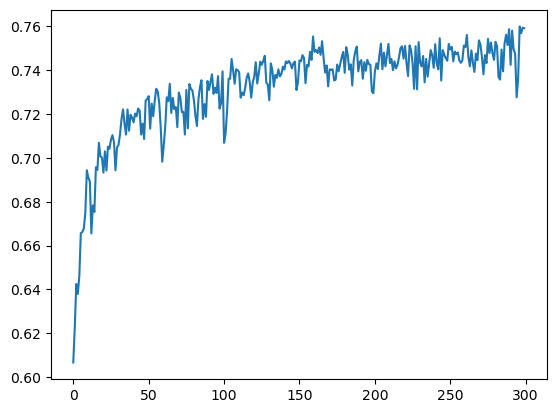

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

testx = np.arange(300)
plt.plot(testx, test[6])
plt.show()